In [1]:
import pandas as pd
import numpy as np
import pathlib
import cv2
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, SpatialDropout2D, Concatenate, LeakyReLU, BatchNormalization, Activation, Dropout
%matplotlib inline
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

In [2]:
# variables & constants
PATH_BASE = pathlib.Path("__file__").parents[0]
PATH_TRAIN_IMAGE_FOLDER = PATH_BASE.joinpath("data","train")
PATH_TRAIN_METADATA = PATH_BASE.joinpath("data","train.csv")

RANDOM_STATE = 19
INPUT_IMG_SHAPE = (520, 704) # height, weight for raw train images
TARGET_IMG_SHAPE = (512, 704) # height, weight for data after transformation
TRANS_POWER = 2
LEARNING_RATE = 1e-4
VAL_SIZE = 0.1
BATCH_SIZE = 4
EPOCHS = 50
PLOTS_DPI = 150
PATIENCE = 6

np.random.seed(RANDOM_STATE)


In [3]:
# funcs
def get_image_paths(path: pathlib.Path) -> List[pathlib.Path]:
    """
    Function to Combine Directory Path with individual Image Paths
    """

    image_paths = []
    for filepath in path.iterdir():
        image_paths.append(filepath)
    return image_paths

def get_image_and_reshape(path_single_image: pathlib, image_shape: Tuple[int, int]) -> Tuple[np.ndarray, str]:
    """Function to load image and reshape to desired shape"""
    
    image_id = path_single_image.name.replace(".png", "")
    image=cv2.imread(str(path_single_image), cv2.IMREAD_GRAYSCALE) #cv2 imread takes only str
    return image.reshape(*image_shape, 1), image_id


def plot_multiple_img(images: List[np.ndarray], rows: int, cols: int) -> None:
    """
    Display images from dataset.
    """
    
    _, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(16,8))
    for ind, image in enumerate(images):        
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

def rle_decode(mask_rle: str,  shape: Tuple[int, int, int], color: int = 1) -> np.ndarray:
    """
    Run-Length decoding.

    mask_rle: run-length as string formated (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """ 

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros((shape[0] * shape[1], shape[2]), dtype = np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = color
    return img.reshape(shape)

def grayscale_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
    """ Create grayscale mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

    grayscale_mask = np.zeros((shape[0], shape[1], shape[2]))
    
    for annot in annots:
            grayscale_mask += rle_decode(annot, shape)
    
    return grayscale_mask.clip(0, 1)

def rgb_mask(annots: str, shape: Tuple[int, int, int]) -> np.ndarray:
    """ Create RGB mask from rle-mask(s). run-length-mask are encoded as string (start length)"""

    rgb_mask = np.zeros((shape[0], shape[1], shape[2]))
    
    for annot in annots:
        rgb_mask += rle_decode(mask_rle=annot, shape=shape, color=np.random.rand(3))
    
    return rgb_mask.clip(0, 1)

def plot_image_with_annot(image: np.ndarray, rle_masks: str, img_2d_shape: Tuple[int, int], normalize_hist:bool=True) -> None:
    """Plot image with rle-mask in greyscale and in rbg"""

    grayscale_masks=grayscale_mask(rle_masks, shape=(*img_2d_shape, 1))
    rgb_masks=rgb_mask(rle_masks, shape=(*img_2d_shape, 3))

    plt.figure(figsize = (20 , 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap = "gray")
    plt.title("Original Image", fontsize = 16)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(image * grayscale_masks, cmap = "gray")
    plt.title('Input image with mask', fontsize = 16)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(rgb_masks)
    plt.title('RGB mask', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    if normalize_hist:
        plt.hist(image.flatten() / 255, bins = 255, range = (0, 1))
    else:
        plt.hist(image.flatten(), bins=255, range=(0, 1))
    plt.title('Pixel distribution', fontsize = 16)
    
    plt.suptitle("For a sample image, masks and their pixel distributions", fontsize = 20)
    plt.tight_layout(rect = [0, 0, 0.90, 1])
    plt.show()


def transform_image_contrast(img_data: np.ndarray, power:int = 2) -> np.ndarray:
    img_data_mask = np.ones_like(img_data, dtype = np.int16)
    img_data_mask[img_data < 127.5] = -1
    
    img_data_transformed = img_data.astype(np.int16) - 127.5
    img_data_transformed[img_data_transformed > 0] = np.power(img_data_transformed[img_data_transformed > 0], 1 / power)
    img_data_transformed[img_data_transformed < 0] = np.power(-img_data_transformed[img_data_transformed < 0], 1 / power)
    img_data_transformed = ((img_data_transformed * img_data_mask) / (2 * np.power(127.5, 1 / power))) + 0.5
    
    return img_data_transformed


In [4]:
# read data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)
train_metadata.head(2)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [5]:
# Explore the metadata
print(f"Shape of the train meta-data is: {train_metadata.shape}")
print(f"There is the following missing data: \n{train_metadata.isnull().sum()}")
print(f"Number of unique images: {train_metadata.id.nunique()}")
print(f"These are the cell types in the data: {list(train_metadata.cell_type.unique())}")

Shape of the train meta-data is: (73585, 9)
There is the following missing data: 
id                   0
annotation           0
width                0
height               0
cell_type            0
plate_time           0
sample_date          0
sample_id            0
elapsed_timedelta    0
dtype: int64
Number of unique images: 606
These are the cell types in the data: ['shsy5y', 'astro', 'cort']


In [6]:
# Explore the metadata in respect to the images (height and width)
train_metadata[["height", "width"]].describe()

,height,width
count,73585.0,73585.0
mean,520.0,704.0
std,0.0,0.0
min,520.0,704.0
25%,520.0,704.0
50%,520.0,704.0
75%,520.0,704.0
max,520.0,704.0


In [7]:
# Number of annotations per image
train_metadata.groupby("id")[["annotation"]].count().sort_values("annotation")

,annotation
id,
e92c56871769,4
eec79772cb99,5
b861811eaff6,5
c25db38e918e,6
7f21996da2e6,8
...,...
e8ae919aa92e,605
aff8fb4fc364,609
e748ac1c469b,703


Explore the images by loading them and displaying without and with the annotations

In [8]:
## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
train_images_paths = get_image_paths(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, INPUT_IMG_SHAPE) for train_image_path in train_images_paths]
train_images_dict = {image_id: image for image, image_id in train_images}

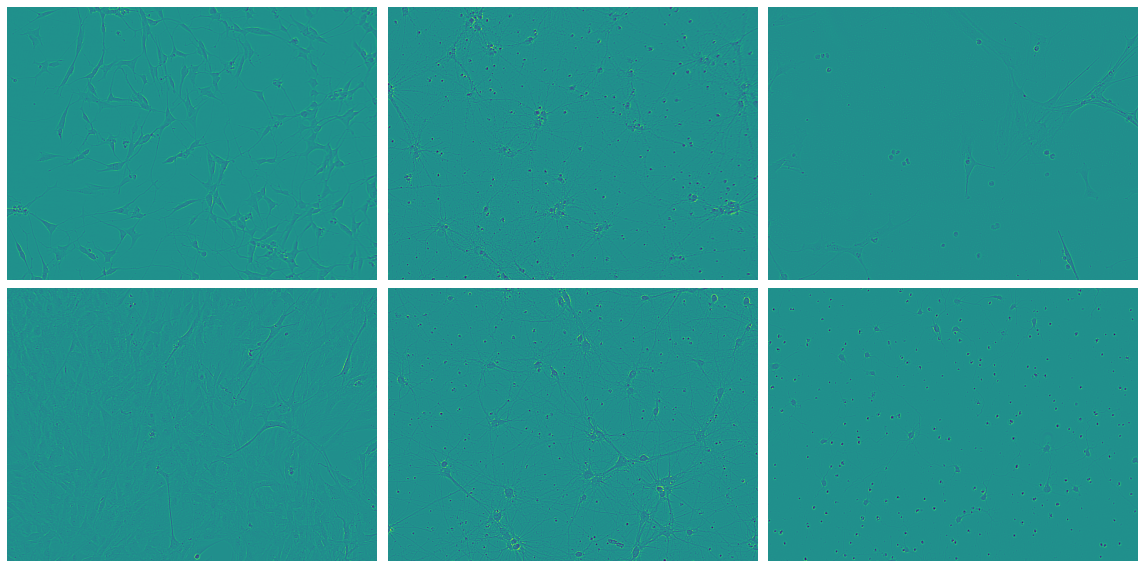

In [9]:
# Plot images without annotations
number_of_images = 6
cols = 3
rows = int(number_of_images/ cols)
images = list(train_images_dict.values())[:number_of_images]
plot_multiple_img(images, rows, cols)

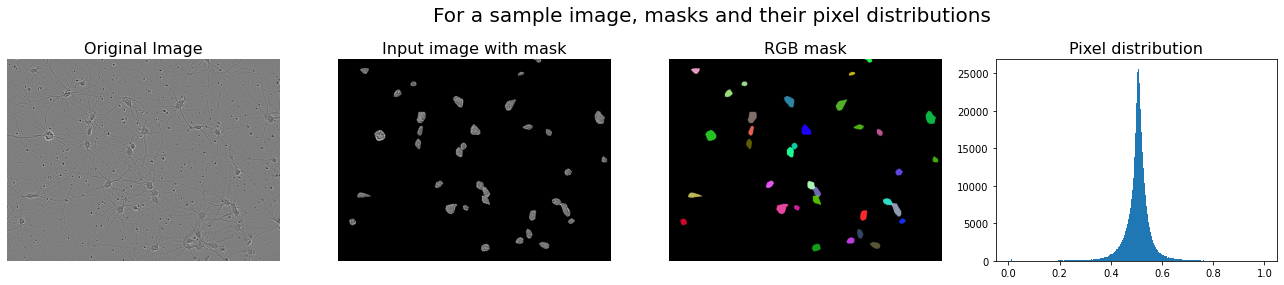

In [10]:
# Plot random image with annotations and pixel distributions
rnd_int=np.random.randint(len(train_images_dict))
rnd_image_id=list(train_images_dict.keys())[rnd_int]
row=train_metadata[train_metadata["id"] == rnd_image_id]
annots=row["annotation"].tolist()
cell_type=row["cell_type"].tolist()[0]
image=train_images_dict[rnd_image_id]
plot_image_with_annot(image, annots, img_2d_shape=INPUT_IMG_SHAPE)


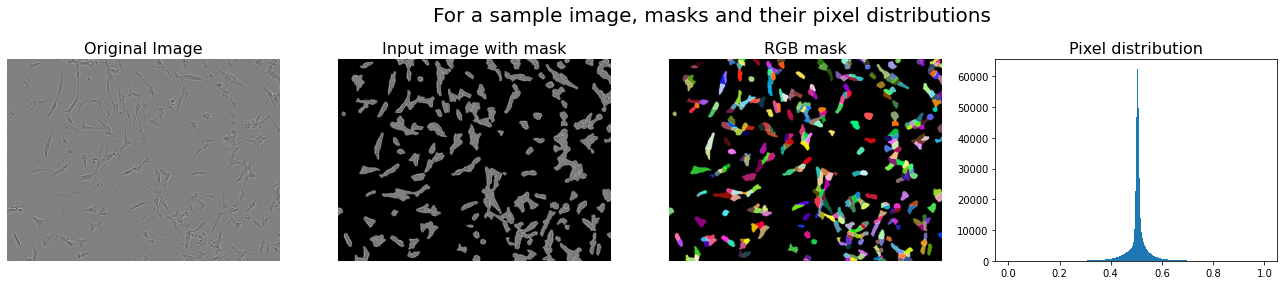

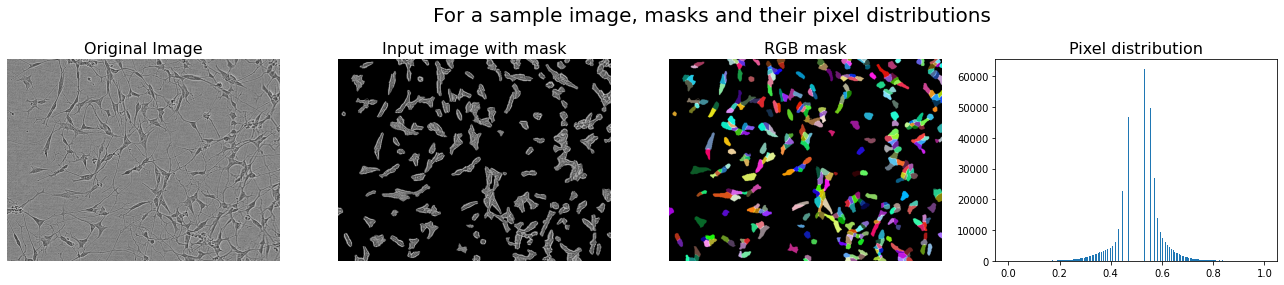

In [11]:
image_id = "b89f9cca5384"
image=train_images_dict[image_id]
image_transformed=transform_image_contrast(image, power=TRANS_POWER)

annots=train_metadata[train_metadata["id"] == image_id]["annotation"].tolist()
plot_image_with_annot(image, annots, img_2d_shape=INPUT_IMG_SHAPE, normalize_hist=True)
plot_image_with_annot(image_transformed, annots, img_2d_shape=INPUT_IMG_SHAPE, normalize_hist=False)


Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

In [23]:
### something is wrong with y in this function
### y has always the same mask

image_ids=list(train_images_dict.keys())
np.random.shuffle(image_ids)

X = []
y = []

for imd_id in image_ids:
    # prepare x
    image = train_images_dict[imd_id]
    prepared_x = cv2.resize(transform_image_contrast(image, TRANS_POWER), (TARGET_IMG_SHAPE[1], TARGET_IMG_SHAPE[0])) # resize 2d
    X.append(prepared_x.reshape(*TARGET_IMG_SHAPE, 1)) # reshape to 3d

    # prepare y
    annots=train_metadata[train_metadata["id"] == image_id]["annotation"].tolist()
    prepared_y = cv2.resize(grayscale_mask(annots, (*INPUT_IMG_SHAPE, 1)), (TARGET_IMG_SHAPE[1], TARGET_IMG_SHAPE[0]))
    y.append(prepared_y.reshape(*TARGET_IMG_SHAPE, 1))

X = np.array(X)
y = np.array(y)
y = Binarizer().transform(y.reshape(-1, 1)).reshape(y.shape) # make y (segmentation labels) binary


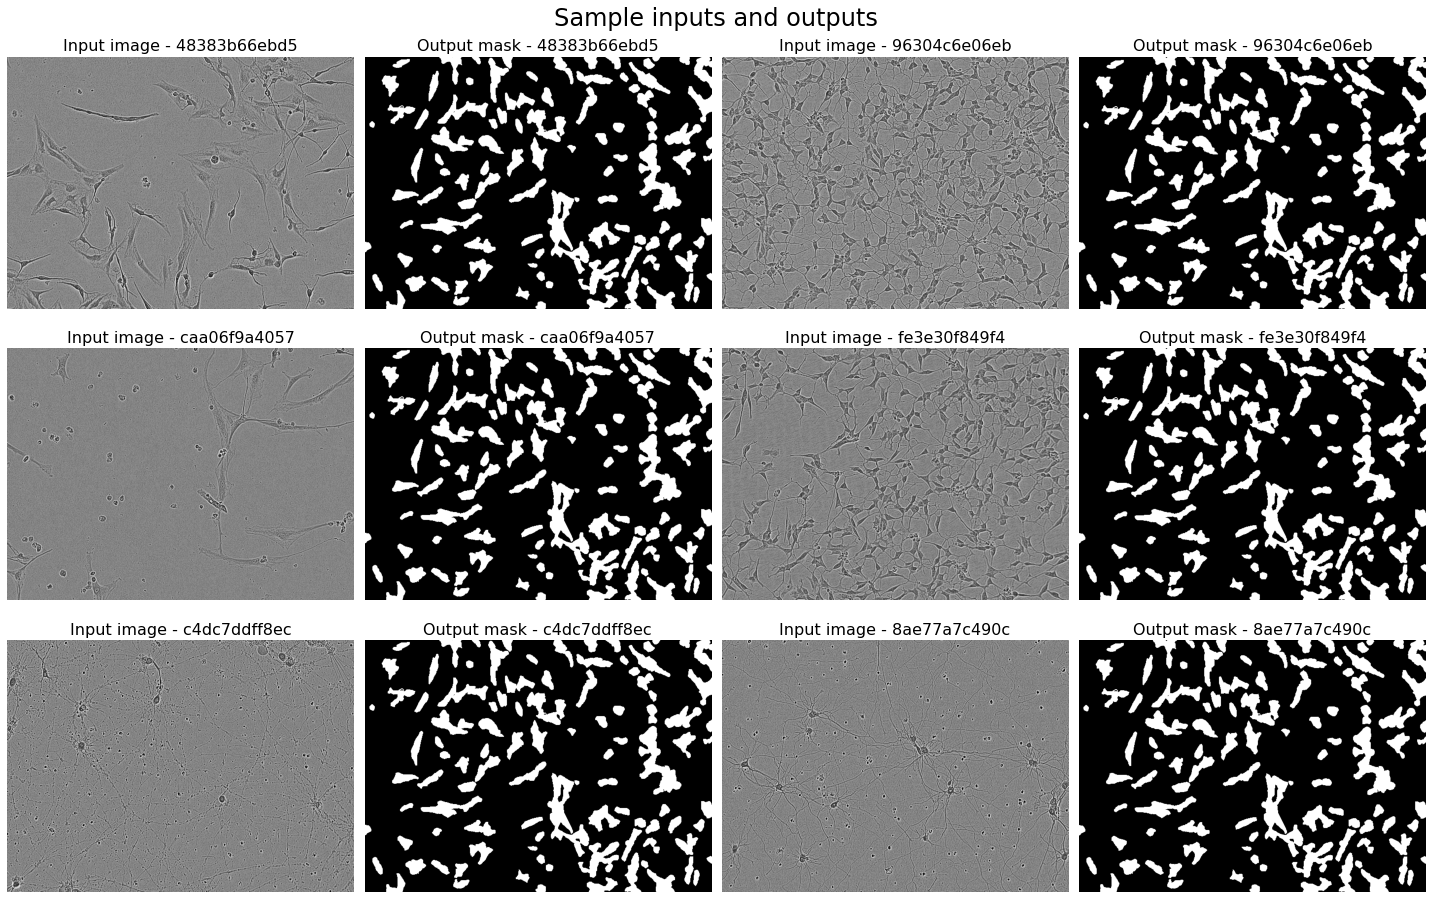

In [34]:
plt.figure(figsize = (20 , 13))

for idx_cnt, idx_rnd_image in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (idx_cnt * 2) + 1)
    plt.imshow(X[idx_rnd_image], cmap = 'gray')
    plt.title(f'Input image - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (idx_cnt * 2) + 2)
    plt.imshow(y[idx_rnd_image], cmap = 'gray')
    plt.title(f'Output mask - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

In [24]:
def unet_model(input_img_shape: Tuple[int,int,int]):
    input_layer = Input(shape = input_img_shape, name = 'Input_Layer')
    
    conv_1 = Conv2D(16, 5, padding = 'same', activation = LeakyReLU(), name = 'Conv_1')(input_layer)
    pool_1 = MaxPool2D(name = 'Max_Pool_1')(conv_1)
    spd_1 = SpatialDropout2D(0.1, name = 'SPD_1')(pool_1)
    
    conv_2 = Conv2D(32, 4, padding = 'same', activation = LeakyReLU(), name = 'Conv_2')(spd_1)
    pool_2 = MaxPool2D(name = 'Max_Pool_2')(conv_2)  
    conv_3 = Conv2D(64, 4, padding = 'same', activation = LeakyReLU(), name = 'Conv_3')(pool_2)
    pool_3 = MaxPool2D(name = 'Max_Pool_3')(conv_3)
    spd_2 = SpatialDropout2D(0.1, name = 'SPD_2')(pool_3)
    
    conv_4 = Conv2D(128, 3, padding = 'same', activation = LeakyReLU(), name = 'Conv_4')(spd_2)
    pool_4 = MaxPool2D(name = 'Max_Pool_4')(conv_4)
    conv_5 = Conv2D(256, 3, padding = 'same', activation = LeakyReLU(), name = 'Conv_5')(pool_4)
    pool_5 = MaxPool2D(name = 'Max_Pool_5')(conv_5)
    spd_3 = SpatialDropout2D(0.1, name = 'SPD_3')(pool_5)
    
    conv_6 = Conv2D(512, 2, padding = 'same', activation = LeakyReLU(), name = 'Conv_6')(spd_3)
    pool_6 = MaxPool2D(name = 'Max_Pool_6')(conv_6)
    
    conv_t_1 = Conv2DTranspose(256, 1, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_1')(pool_6)
    concat_1 = Concatenate(name = 'Concat_1')([conv_t_1, spd_3])
    spd_4 = SpatialDropout2D(0.1, name = 'SPD_4')(concat_1)
    
    conv_t_2 = Conv2DTranspose(128, 3, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_2')(spd_4)
    conv_t_3 = Conv2DTranspose(64, 3, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_3')(conv_t_2)
    concat_2 = Concatenate(name = 'Concat_2')([conv_t_3, spd_2])
    spd_5 = SpatialDropout2D(0.1, name = 'SPD_5')(concat_2)
    
    conv_t_4 = Conv2DTranspose(32, 4, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_4')(spd_5)
    conv_t_5 = Conv2DTranspose(16, 4, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_5')(conv_t_4)
    concat_3 = Concatenate(name = 'Concat_3')([conv_t_5, spd_1])
    spd_6 = SpatialDropout2D(0.1, name = 'SPD_6')(concat_3)
    
    conv_t_6 = Conv2DTranspose(8, 5, padding = 'same', strides = 2, activation = LeakyReLU(), name = 'Conv_T_6')(spd_6)
    
    output_layer = Conv2DTranspose(1, 5, padding = 'same', activation = 'sigmoid', name = 'Output_Layer')(conv_t_6)
    
    return Model(inputs = input_layer, outputs = output_layer, name = 'Sartorius')

In [25]:
model=unet_model((*TARGET_IMG_SHAPE, 1))
model.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Sartorius"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 704, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 512, 704, 16) 416         Input_Layer[0][0]                
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 256, 352, 16) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
SPD_1 (SpatialDropout2D)        (None, 256, 352, 16) 0           Max_Pool_1[0][0]                 
__________________________________________________________________________________________

In [26]:
%%time
tf.debugging.set_log_device_placement(True)

# tf.profiler.experimental.server.start(6006)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=(10,20,50), embeddings_freq=0, embeddings_metadata=None,
)

early_stop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
with tf.device('/device:GPU:1'):
    history = model.fit(
        X, y,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_split = VAL_SIZE,
        callbacks = [early_stop, tb_callback]
    )

Epoch 1/50
137/137 [==============================] - 5s 32ms/step - loss: 0.5562 - accuracy: 0.7777 - val_loss: 0.5145 - val_accuracy: 0.7871
Epoch 2/50
137/137 [==============================] - 4s 28ms/step - loss: 0.5086 - accuracy: 0.7871 - val_loss: 0.4928 - val_accuracy: 0.7874
Epoch 3/50
137/137 [==============================] - 4s 28ms/step - loss: 0.4910 - accuracy: 0.7888 - val_loss: 0.4815 - val_accuracy: 0.7918
Epoch 4/50
137/137 [==============================] - 4s 28ms/step - loss: 0.4764 - accuracy: 0.7947 - val_loss: 0.4679 - val_accuracy: 0.7973
Epoch 5/50
137/137 [==============================] - 4s 28ms/step - loss: 0.4679 - accuracy: 0.7973 - val_loss: 0.4617 - val_accuracy: 0.7986
Epoch 6/50
137/137 [==============================] - 4s 28ms/step - loss: 0.4646 - accuracy: 0.7983 - val_loss: 0.4600 - val_accuracy: 0.7991
Epoch 7/50
137/137 [==============================] - 4s 28ms/step - loss: 0.4626 - accuracy: 0.7987 - val_loss: 0.4590 - val_accuracy: 0.7994

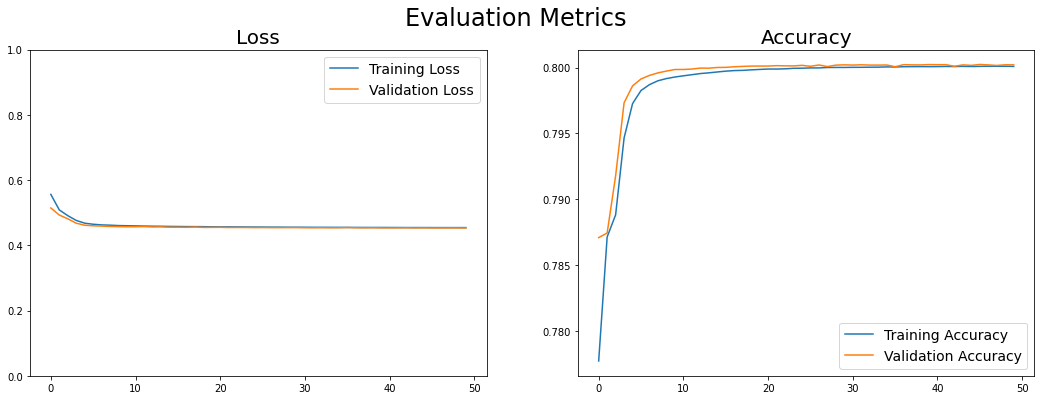

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = history.epoch

plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, 1)
plt.title('Loss', fontsize = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right', fontsize = 14)
plt.title('Accuracy', fontsize = 20)

plt.suptitle("Evaluation Metrics", fontsize = 24)
plt.savefig('loss_and_accuracy.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

In [22]:
%reload_ext tensorboard